# Libraries

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

/home/vrtx26/.local/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [3]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.003998756408691406 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.010998964309692383ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [3]:
X, y, ID = data_loader.load_dataset(X_path='data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.08658099174499512ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

## Relabeling and normilizing

In [6]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='calm')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e+02, tolerance: 6.656e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e+02, tolerance: 6.656e-02

Text(0, 0.5, 'Coeffs')

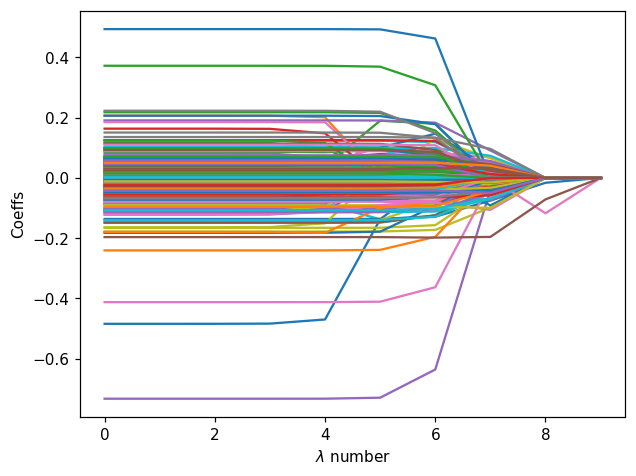

In [7]:
Lasso_model = linear_model.Lasso()
Npt = 10
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [8]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [9]:
np.save('data/Lasso_Ranking_calm_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_calm_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.7115
Iter =  2  AUC = 0.7905
Iter =  3  AUC = 0.8001
Iter =  4  AUC = 0.8005
Iter =  5  AUC = 0.8201
Iter =  6  AUC = 0.8237
Iter =  13  AUC = 0.8241
Iter =  14  AUC = 0.8259
Iter =  15  AUC = 0.8305
Iter =  22  AUC = 0.8357
Iter =  23  AUC = 0.8359
Iter =  25  AUC = 0.8387
Iter =  26  AUC = 0.8395
Iter =  27  AUC = 0.8512
Iter =  28  AUC = 0.8546
Iter =  34  AUC = 0.8572
Iter =  61  AUC = 0.8622
Iter =  62  AUC = 0.8630
Iter =  63  AUC = 0.8644
Iter =  78  AUC = 0.8652
auc_best = 0.86518429


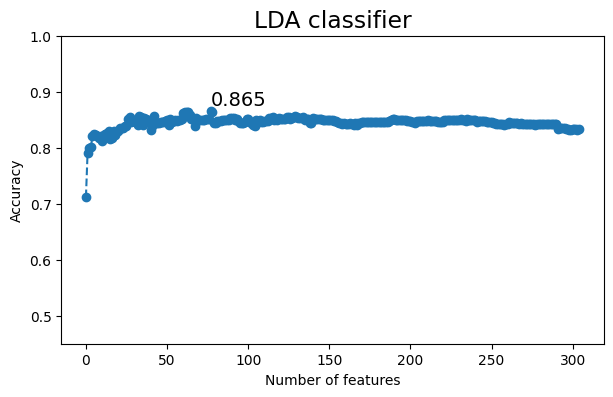

In [10]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [11]:
print('best auc (LDA) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

best auc (LDA) =  0.8651842948717949 Number of features =  77


# Backward step selection

In [12]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)
         
         print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [13]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND
Iter #0: 0.858 <-> 0.865
Iter #1: 0.865 <-> 0.865
Iter #2: 0.865 <-> 0.865
Iter #3: 0.865 <-> 0.865
Iter #4: 0.857 <-> 0.865
Iter #5: 0.861 <-> 0.865
Iter #6: 0.865 <-> 0.865
Iter #7: 0.860 <-> 0.865
Iter #8: 0.870 <-> 0.865
Iter #9: 0.866 <-> 0.865
Iter #10: 0.862 <-> 0.865
Iter #11: 0.866 <-> 0.865
Iter #12: 0.863 <-> 0.865
Iter #13: 0.868 <-> 0.865
Iter #14: 0.866 <-> 0.865
Iter #15: 0.865 <-> 0.865
Iter #16: 0.857 <-> 0.865
Iter #17: 0.853 <-> 0.865
Iter #18: 0.868 <-> 0.865
Iter #19: 0.861 <-> 0.865
Iter #20: 0.863 <-> 0.865
Iter #21: 0.863 <-> 0.865
Iter #22: 0.863 <-> 0.865
Iter #23: 0.865 <-> 0.865
Iter #24: 0.855 <-> 0.865
Iter #25: 0.866 <-> 0.865
Iter #26: 0.858 <-> 0.865
Iter #27: 0.865 <-> 0.865
Iter #28: 0.860 <-> 0.865
Iter #29: 0.863 <-> 0.865
Iter #30: 0.865 <-> 0.865
Iter #31: 0.866 <-> 0.865
Iter #32: 0.865 <-> 0.865
Iter #33: 0.863 <-> 0.865
Iter #34: 0.861 <-> 0.865
Iter #35: 0.863 <-> 0.865
Iter #36: 0.865 <-> 0.865
Iter #37: 0.862 <-> 0.865
Iter #38: 0.

Iter #4: 0.867 <-> 0.867
Iter #5: 0.870 <-> 0.867
Iter #6: 0.869 <-> 0.867
Iter #7: 0.864 <-> 0.867
Iter #8: 0.854 <-> 0.867
Iter #9: 0.868 <-> 0.867
Iter #10: 0.866 <-> 0.867
Iter #11: 0.864 <-> 0.867
Iter #12: 0.864 <-> 0.867
Iter #13: 0.869 <-> 0.867
Iter #14: 0.863 <-> 0.867
Iter #15: 0.865 <-> 0.867
Iter #16: 0.861 <-> 0.867
Iter #17: 0.868 <-> 0.867
Iter #18: 0.859 <-> 0.867
Iter #19: 0.865 <-> 0.867
Iter #20: 0.863 <-> 0.867
Iter #21: 0.869 <-> 0.867
Iter #22: 0.869 <-> 0.867
Iter #23: 0.866 <-> 0.867
Iter #24: 0.867 <-> 0.867
Iter #25: 0.864 <-> 0.867
Iter #26: 0.862 <-> 0.867
Iter #27: 0.868 <-> 0.867
Iter #28: 0.866 <-> 0.867
Iter #29: 0.863 <-> 0.867
Iter #30: 0.866 <-> 0.867
Iter #31: 0.875 <-> 0.867
Iter #32: 0.870 <-> 0.867
Iter #33: 0.869 <-> 0.867
Iter #34: 0.869 <-> 0.867
Iter #35: 0.867 <-> 0.867
Iter #36: 0.862 <-> 0.867
Iter #37: 0.866 <-> 0.867
Iter #38: 0.869 <-> 0.867
Iter #39: 0.869 <-> 0.867
Iter #40: 0.869 <-> 0.867
Iter #41: 0.860 <-> 0.867
Iter #42: 0.869 <-

Iter #24: 0.870 <-> 0.870
Iter #25: 0.869 <-> 0.870
Iter #26: 0.870 <-> 0.870
Iter #27: 0.863 <-> 0.870
Iter #28: 0.870 <-> 0.870
Iter #29: 0.870 <-> 0.870
Iter #30: 0.870 <-> 0.870
Iter #31: 0.870 <-> 0.870
Iter #32: 0.868 <-> 0.870
Iter #33: 0.871 <-> 0.870
Iter #34: 0.869 <-> 0.870
Iter #35: 0.869 <-> 0.870
Iter #36: 0.869 <-> 0.870
Iter #37: 0.871 <-> 0.870
Iter #38: 0.870 <-> 0.870
Iter #39: 0.868 <-> 0.870
Iter #40: 0.871 <-> 0.870
Iter #41: 0.870 <-> 0.870
Iter #42: 0.872 <-> 0.870
Iter #43: 0.866 <-> 0.870
Iter #44: 0.871 <-> 0.870
Iter #45: 0.864 <-> 0.870
Iter #46: 0.861 <-> 0.870
Iter #47: 0.867 <-> 0.870
Iter #48: 0.868 <-> 0.870
Iter #49: 0.869 <-> 0.870
Iter #50: 0.870 <-> 0.870
Iter #51: 0.871 <-> 0.870
Iter #52: 0.863 <-> 0.870
Iter #53: 0.868 <-> 0.870
Iter #54: 0.862 <-> 0.870
Iter #55: 0.865 <-> 0.870
Iter #56: 0.873 <-> 0.870
Iter #57: 0.871 <-> 0.870
Iter #58: 0.869 <-> 0.870
Iter #59: 0.874 <-> 0.870
Iter #60: 0.863 <-> 0.870
Iter #61: 0.868 <-> 0.870
Iter #62: 0.

Iter #60: 0.866 <-> 0.876
Iter #61: 0.871 <-> 0.876
Iter #62: 0.866 <-> 0.876
Iter #63: 0.872 <-> 0.876
Iter #64: 0.868 <-> 0.876
Iter #65: 0.866 <-> 0.876
Withdraw feature #11, added accracy 0
NEW ROUND
Iter #0: 0.864 <-> 0.880
Iter #1: 0.875 <-> 0.880
Iter #2: 0.865 <-> 0.880
Iter #3: 0.862 <-> 0.880
Iter #4: 0.864 <-> 0.880
Iter #5: 0.867 <-> 0.880
Iter #6: 0.868 <-> 0.880
Iter #7: 0.863 <-> 0.880
Iter #8: 0.863 <-> 0.880
Iter #9: 0.880 <-> 0.880
Iter #10: 0.856 <-> 0.880
Iter #11: 0.861 <-> 0.880
Iter #12: 0.876 <-> 0.880
Iter #13: 0.873 <-> 0.880
Iter #14: 0.880 <-> 0.880
Iter #15: 0.878 <-> 0.880
Iter #16: 0.865 <-> 0.880
Iter #17: 0.866 <-> 0.880
Iter #18: 0.860 <-> 0.880
Iter #19: 0.880 <-> 0.880
Iter #20: 0.861 <-> 0.880
Iter #21: 0.880 <-> 0.880
Iter #22: 0.872 <-> 0.880
Iter #23: 0.879 <-> 0.880
Iter #24: 0.879 <-> 0.880
Iter #25: 0.879 <-> 0.880
Iter #26: 0.879 <-> 0.880
Iter #27: 0.860 <-> 0.880
Iter #28: 0.877 <-> 0.880
Iter #29: 0.879 <-> 0.880
Iter #30: 0.879 <-> 0.880


Iter #48: 0.881 <-> 0.884
Iter #49: 0.882 <-> 0.884
Iter #50: 0.887 <-> 0.884
Iter #51: 0.860 <-> 0.884
Iter #52: 0.883 <-> 0.884
Iter #53: 0.864 <-> 0.884
Iter #54: 0.884 <-> 0.884
Iter #55: 0.866 <-> 0.884
Iter #56: 0.884 <-> 0.884
Iter #57: 0.864 <-> 0.884
Iter #58: 0.884 <-> 0.884
Iter #59: 0.866 <-> 0.884
Iter #60: 0.866 <-> 0.884
Withdraw feature #12, added accracy 0
NEW ROUND
Iter #0: 0.868 <-> 0.885
Iter #1: 0.867 <-> 0.885
Iter #2: 0.884 <-> 0.885
Iter #3: 0.864 <-> 0.885
Iter #4: 0.867 <-> 0.885
Iter #5: 0.864 <-> 0.885
Iter #6: 0.874 <-> 0.885
Iter #7: 0.868 <-> 0.885
Iter #8: 0.860 <-> 0.885
Iter #9: 0.865 <-> 0.885
Iter #10: 0.883 <-> 0.885
Iter #11: 0.882 <-> 0.885
Iter #12: 0.881 <-> 0.885
Iter #13: 0.887 <-> 0.885
Iter #14: 0.864 <-> 0.885
Iter #15: 0.866 <-> 0.885
Iter #16: 0.881 <-> 0.885
Iter #17: 0.878 <-> 0.885
Iter #18: 0.884 <-> 0.885
Iter #19: 0.865 <-> 0.885
Iter #20: 0.865 <-> 0.885
Iter #21: 0.884 <-> 0.885
Iter #22: 0.883 <-> 0.885
Iter #23: 0.885 <-> 0.885


Iter #4: 0.873 <-> 0.891
Iter #5: 0.866 <-> 0.891
Iter #6: 0.868 <-> 0.891
Iter #7: 0.880 <-> 0.891
Iter #8: 0.868 <-> 0.891
Iter #9: 0.893 <-> 0.891
Iter #10: 0.893 <-> 0.891
Iter #11: 0.873 <-> 0.891
Iter #12: 0.870 <-> 0.891
Iter #13: 0.869 <-> 0.891
Iter #14: 0.892 <-> 0.891
Iter #15: 0.883 <-> 0.891
Iter #16: 0.891 <-> 0.891
Iter #17: 0.891 <-> 0.891
Iter #18: 0.869 <-> 0.891
Iter #19: 0.869 <-> 0.891
Iter #20: 0.869 <-> 0.891
Iter #21: 0.869 <-> 0.891
Iter #22: 0.874 <-> 0.891
Iter #23: 0.891 <-> 0.891
Iter #24: 0.890 <-> 0.891
Iter #25: 0.891 <-> 0.891
Iter #26: 0.891 <-> 0.891
Iter #27: 0.888 <-> 0.891
Iter #28: 0.865 <-> 0.891
Iter #29: 0.876 <-> 0.891
Iter #30: 0.885 <-> 0.891
Iter #31: 0.861 <-> 0.891
Iter #32: 0.870 <-> 0.891
Iter #33: 0.870 <-> 0.891
Iter #34: 0.891 <-> 0.891
Iter #35: 0.895 <-> 0.891
Iter #36: 0.885 <-> 0.891
Iter #37: 0.856 <-> 0.891
Iter #38: 0.890 <-> 0.891
Iter #39: 0.872 <-> 0.891
Iter #40: 0.882 <-> 0.891
Iter #41: 0.891 <-> 0.891
Iter #42: 0.887 <-

Iter #48: 0.873 <-> 0.896
Iter #49: 0.872 <-> 0.896
Withdraw feature #14, added accracy 0
NEW ROUND
Iter #0: 0.841 <-> 0.896
Iter #1: 0.874 <-> 0.896
Iter #2: 0.871 <-> 0.896
Iter #3: 0.890 <-> 0.896
Iter #4: 0.861 <-> 0.896
Iter #5: 0.840 <-> 0.896
Iter #6: 0.835 <-> 0.896
Iter #7: 0.895 <-> 0.896
Iter #8: 0.843 <-> 0.896
Iter #9: 0.837 <-> 0.896
Iter #10: 0.894 <-> 0.896
Iter #11: 0.892 <-> 0.896
Iter #12: 0.892 <-> 0.896
Iter #13: 0.889 <-> 0.896
Iter #14: 0.873 <-> 0.896
Iter #15: 0.893 <-> 0.896
Iter #16: 0.893 <-> 0.896
Iter #17: 0.889 <-> 0.896
Iter #18: 0.893 <-> 0.896
Iter #19: 0.893 <-> 0.896
Iter #20: 0.893 <-> 0.896
Iter #21: 0.896 <-> 0.896
Iter #22: 0.879 <-> 0.896
Iter #23: 0.891 <-> 0.896
Iter #24: 0.891 <-> 0.896
Iter #25: 0.866 <-> 0.896
Iter #26: 0.871 <-> 0.896
Iter #27: 0.884 <-> 0.896
Iter #28: 0.896 <-> 0.896
Iter #29: 0.894 <-> 0.896
Iter #30: 0.890 <-> 0.896
Iter #31: 0.877 <-> 0.896
Iter #32: 0.893 <-> 0.896
Iter #33: 0.870 <-> 0.896
Iter #34: 0.871 <-> 0.896


In [ ]:
np.save('data/feature_idx_calm.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_calm.npy')

# 5-fold CV (full feature space)

In [15]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.90it/s]

UAR = 0.391


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.76it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.78it/s]

UAR = 0.419


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.46it/s]

UAR = 0.436


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.67it/s]

UAR = 0.456


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.86it/s]

UAR = 0.454


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.70it/s]

UAR = 0.444


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.93it/s]

UAR = 0.436


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.23it/s]

UAR = 0.429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


UAR = 0.423
UAR_best = 0.456, C_best = 0.004


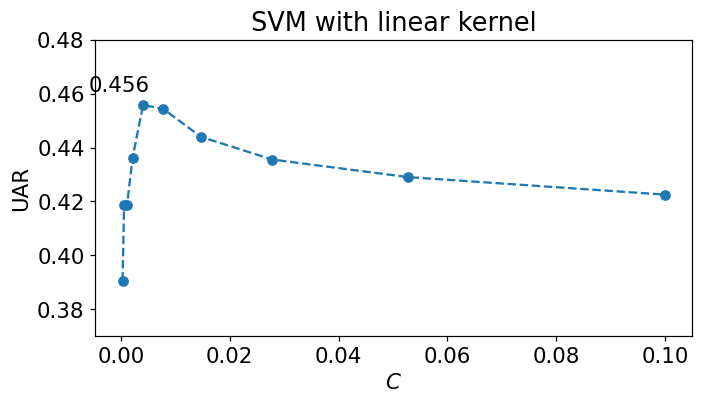

In [16]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

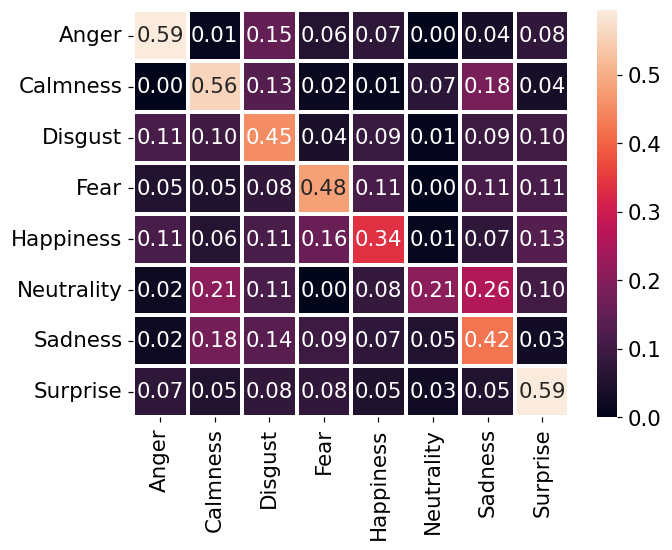

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [17]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [18]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [23]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.540508,-0.125111,1.150804,1.972389,1.136402,0.880731,3.253256,0.827516,0.504176,1.410258,...,0.159116,0.039352,-0.798941,1.498376,3.205445,1.910680,0.378692,-0.542375,-0.772935,-0.134175
1,0.073293,1.343100,0.672050,0.647493,0.712442,-0.414623,1.911722,-1.320254,-0.327486,0.563581,...,0.936533,-0.917435,-0.173629,-0.672245,1.282987,-0.773068,-0.966724,-0.898757,-0.499137,-0.384878
2,-0.238024,-0.256055,-0.060220,0.152506,0.594105,0.916093,1.161570,-0.790393,-0.100742,-0.253994,...,0.230524,0.589061,0.177662,0.017010,1.024253,-0.544117,-0.800947,-0.504110,-0.387172,0.685220
3,-0.123225,-0.107841,1.136290,1.409404,0.547577,1.349649,2.585998,-0.305098,1.799545,0.584220,...,-0.449243,-0.421318,0.273819,-0.452109,0.677401,-0.158775,1.074379,0.726495,0.289265,0.561642
4,-0.843281,0.020091,1.376167,1.757624,0.859079,1.688633,3.082187,1.680597,1.282220,0.307135,...,-0.240188,0.144573,-0.468580,-1.183403,-0.266633,-0.725830,1.049962,0.763248,0.684975,1.999628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.014833,0.642538,0.974003,-0.402387,1.929130,-0.822625,-0.068379,0.637919,0.591201,0.384929,...,-0.404667,-0.523336,-1.409358,-1.458692,0.908425,-0.895657,1.622761,1.591309,1.287652,0.991508
1436,-0.992780,0.246054,-0.475318,0.399012,-0.514948,-0.546806,0.593122,2.429269,1.362496,0.182412,...,-0.126977,-0.362208,-0.688855,-0.337889,0.940510,0.764708,1.612017,1.796934,0.671853,1.087294
1437,-0.087927,0.032885,0.077815,-0.567749,-0.014449,0.256479,0.221267,0.640135,0.730787,0.149253,...,-1.003486,-0.897404,-1.481660,-1.469254,1.378868,1.396386,1.289363,-0.775856,1.297397,1.178085
1438,0.473982,-0.989785,0.042286,0.113842,0.708992,-1.569496,-0.560947,-0.435340,-0.724142,0.172780,...,-0.510099,-0.654117,-1.515311,-1.138011,-2.289985,-0.668682,1.473954,0.937051,0.685952,0.512360


## GridSearch

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.26it/s]

UAR = 0.327


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.55it/s]

UAR = 0.335


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 14.55it/s]

UAR = 0.340


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.77it/s]

UAR = 0.355


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.14it/s]

UAR = 0.367


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.38it/s]

UAR = 0.387


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.62it/s]

UAR = 0.404


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.57it/s]

UAR = 0.407


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.87it/s]

UAR = 0.413


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.36it/s]

UAR = 0.417


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.51it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.34it/s]

UAR = 0.424


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.85it/s]

UAR = 0.431


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.57it/s]

UAR = 0.433


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.53it/s]

UAR = 0.443


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.41it/s]

UAR = 0.437


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.07it/s]

UAR = 0.439


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.25it/s]

UAR = 0.434


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.86it/s]

UAR = 0.432


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 20.97it/s]

UAR = 0.438


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.20it/s]

UAR = 0.443


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.72it/s]

UAR = 0.438


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.73it/s]

UAR = 0.446


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 3/5 [00:00<00:00, 21.79it/s]

UAR = 0.443


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.82it/s]

UAR = 0.448


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.83it/s]

UAR = 0.443


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.45it/s]

UAR = 0.449


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.17it/s]

UAR = 0.440


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.90it/s]

UAR = 0.441


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.76it/s]

UAR = 0.439


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.26it/s]

UAR = 0.435


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.36it/s]

UAR = 0.432


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.74it/s]

UAR = 0.429


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.66it/s]

UAR = 0.423


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 11.81it/s]

UAR = 0.421


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.61it/s]

UAR = 0.423


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.53it/s]

UAR = 0.428


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.79it/s]

UAR = 0.430


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.20it/s]

UAR = 0.426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


UAR = 0.425
UAR_best = 0.449, C_best = 0.068


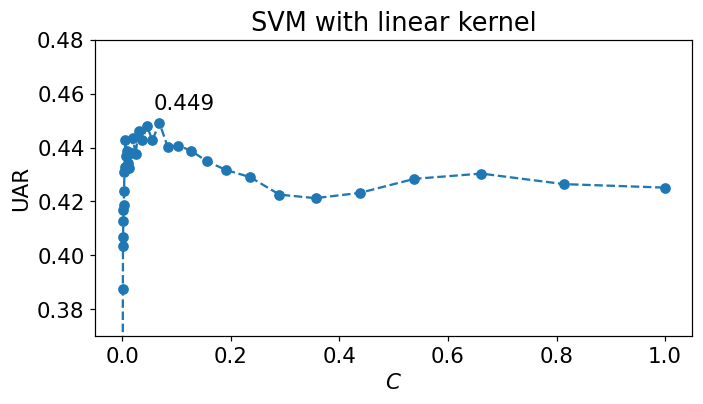

In [19]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

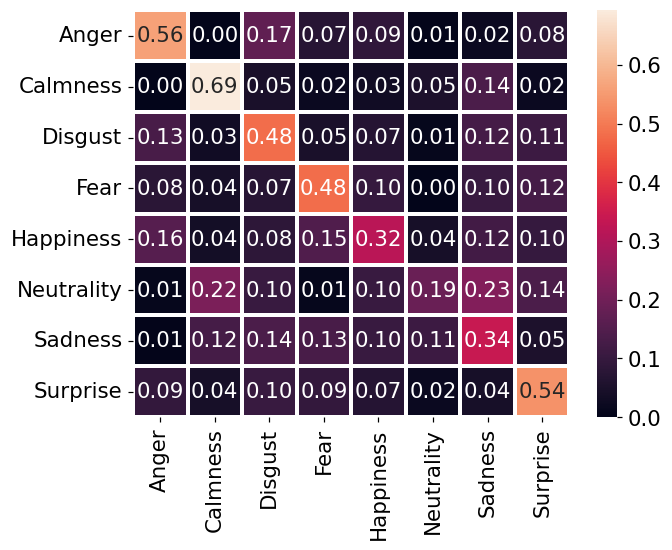

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [20]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)